# Traffic Sign Classifier

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = 'Dataset/train.p'
validation_file = 'Dataset/valid.p'
testing_file = 'Dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Loaded dataset successfully!')

Loaded dataset successfully!


## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
---
### Basic Summary of the Data Set

In [2]:
# Number of training examples
n_train =  len(X_train)
# Number of validation examples
n_validation = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# Check if number of inputs match number of outputs/labels
assert n_train == len(y_train)
assert n_validation == len(y_valid)
assert n_test == len(y_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# Check if shape is constant for training, validation and testing data
assert X_train[0].shape == X_valid[0].shape == X_test[0].shape

# Unique classes/labels that are there in the dataset
with open('signnames.csv', mode='rb') as f:
    n_classes = sum(1 for row in f) - 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


---
### Visualizing the German Traffic Signs Dataset

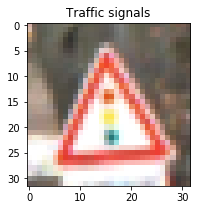

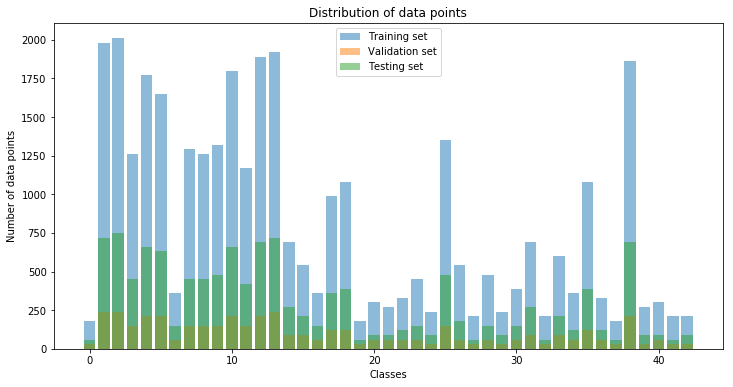

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import pandas as pd
# Visualizations will be shown in the notebook.
%matplotlib inline

df = pd.read_csv('signnames.csv')
label_names = df.SignName.as_matrix()

# Visualize a random sample from the training dataset
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(3,3))
plt.title(label_names[y_train[index]])
plt.imshow(image, cmap="gray")

# Viualize distribution of data points in the training, validation and test dataset
train_bin = np.bincount(y_train)
valid_bin = np.bincount(y_valid)
test_bin = np.bincount(y_test)

index = np.arange(n_classes)
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(index, train_bin, align='center', alpha=0.5, label='Training set')
plt.bar(index, valid_bin, align='center', alpha=0.5, label='Validation set')
plt.bar(index, test_bin, align='center', alpha=0.5, label='Testing set')
plt.title('Distribution of data points')
plt.xlabel('Classes')
plt.ylabel('Number of data points')
plt.legend()

----

## Step 2: Design and Test a Model Architecture

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

---
### Pre-process the Data Set
Minimally, the image data should be normalized so that the data has mean zero and equal variance.

In [4]:
import cv2

def rgb_2_gray(input_array):
    """
    Function to convert array of images from rgb to gray scale
    """
    n_images, img_width, img_height, n_channels = input_array.shape
    
    gray = np.empty([n_images, img_width, img_height])
    for n_img in range(n_images):
        gray[n_img] = cv2.cvtColor(input_array[n_img], cv2.COLOR_BGR2GRAY)
    
    return np.expand_dims(gray, axis=3)

def normalize_gray(gray):
    """
    Function to normalize all pixel values
    """
    return (gray - 128.0)/128.0

In [5]:
# Preprocess training, validation and testing images
print('Before preprocessing:')
print('Training set:', X_train.shape)
print('Validation set:', X_valid.shape)
print('Testing set:', X_test.shape)
print()

X_train = rgb_2_gray(X_train)
X_train = normalize_gray(X_train)

X_valid = rgb_2_gray(X_valid)
X_valid = normalize_gray(X_valid)

X_test = rgb_2_gray(X_test)
X_test = normalize_gray(X_test)

print('After preprocessing:')
print('Training set:', X_train.shape)
print('Validation set:', X_valid.shape)
print('Testing set:', X_test.shape)
print()
print('Preprocessing done!')

Before preprocessing:
Training set: (34799, 32, 32, 3)
Validation set: (4410, 32, 32, 3)
Testing set: (12630, 32, 32, 3)

After preprocessing:
Training set: (34799, 32, 32, 1)
Validation set: (4410, 32, 32, 1)
Testing set: (12630, 32, 32, 1)

Preprocessing done!


### Model Architecture

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

def convNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
        'w_conv1': tf.Variable(tf.truncated_normal([3, 3, 1, 16], mean=mu, stddev=sigma)),
        'w_conv2': tf.Variable(tf.truncated_normal([3, 3, 16, 16], mean=mu, stddev=sigma)),
        'w_conv3': tf.Variable(tf.truncated_normal([3, 3, 16, 32], mean=mu, stddev=sigma)),
        'w_conv4': tf.Variable(tf.truncated_normal([3, 3, 32, 32], mean=mu, stddev=sigma)),
        'w_conv5': tf.Variable(tf.truncated_normal([3, 3, 32, 64], mean=mu, stddev=sigma)),
        'w_conv6': tf.Variable(tf.truncated_normal([3, 3, 64, 64], mean=mu, stddev=sigma)),
        'w_dense1': tf.Variable(tf.truncated_normal([576, 256], mean=mu, stddev=sigma)),
        'w_dense2': tf.Variable(tf.truncated_normal([256, 128], mean=mu, stddev=sigma)),
        'w_dense3': tf.Variable(tf.truncated_normal([128, n_classes], mean=mu, stddev=sigma))
    }

    biases = {
        'b_conv1': tf.Variable(tf.constant(shape=[16], value=0.1, dtype=tf.float32)),
        'b_conv2': tf.Variable(tf.constant(shape=[16], value=0.1, dtype=tf.float32)),
        'b_conv3': tf.Variable(tf.constant(shape=[32], value=0.1, dtype=tf.float32)),
        'b_conv4': tf.Variable(tf.constant(shape=[32], value=0.1, dtype=tf.float32)),
        'b_conv5': tf.Variable(tf.constant(shape=[64], value=0.1, dtype=tf.float32)),
        'b_conv6': tf.Variable(tf.constant(shape=[64], value=0.1, dtype=tf.float32)),
        'b_dense1': tf.Variable(tf.constant(shape=[256], value=0.1, dtype=tf.float32)),
        'b_dense2': tf.Variable(tf.constant(shape=[128], value=0.1, dtype=tf.float32)),
        'b_dense3': tf.Variable(tf.constant(shape=[n_classes], value=0.1, dtype=tf.float32))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x16
    conv1 = tf.nn.conv2d(x, weights['w_conv1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(conv1, biases['b_conv1']))
    
    # Layer 2: Convolutional. Output = 28x28x16
    conv2 = tf.nn.conv2d(conv1, weights['w_conv2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(tf.nn.bias_add(conv2, biases['b_conv2']))
    
    # Layer 3: Convolutional. Output = 26x26x32
    conv3 = tf.nn.conv2d(conv2, weights['w_conv3'], strides=[1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(conv3, biases['b_conv3']))
    
    # Pooling. Input = 26x26x32. Output = 13x13x32.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = tf.nn.dropout(conv3, keep_prob)
    
    # Layer 4: Convolutional. Output = 11x11x32.
    conv4 = tf.nn.conv2d(conv3, weights['w_conv4'], strides=[1, 1, 1, 1], padding='VALID')
    conv4 = tf.nn.relu(tf.nn.bias_add(conv4, biases['b_conv4']))
    
    # Layer 5: Convolutional. Output = 9x9x64.
    conv5 = tf.nn.conv2d(conv4, weights['w_conv5'], strides=[1, 1, 1, 1], padding='VALID')
    conv5 = tf.nn.relu(tf.nn.bias_add(conv5, biases['b_conv5']))
    
    # Layer 6: Convolutional. Output = 7x7x64.
    conv6 = tf.nn.conv2d(conv5, weights['w_conv6'], strides=[1, 1, 1, 1], padding='VALID')
    conv6 = tf.nn.relu(tf.nn.bias_add(conv6, biases['b_conv6']))
    
    # Pooling. Input = 7x7x64. Output = 3x3x64.
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv6 = tf.nn.dropout(conv6, keep_prob)
    
    # Flatten. Input = 3x3x64. Output = 576.
    conv_shape = conv6.get_shape().as_list()
    reshape = tf.reshape(conv6, [-1, conv_shape[1] * conv_shape[2] * conv_shape[3]])
    
    # Layer 3: Fully Connected. Input = 576. Output = 256.
    dense1 = tf.add(tf.matmul(reshape, weights['w_dense1']), biases['b_dense1'])
    dense1 = tf.nn.relu(dense1)
    dense1 = tf.nn.dropout(dense1, keep_prob)

    # Layer 4: Fully Connected. Input = 256. Output = 128.
    dense2 = tf.add(tf.matmul(dense1, weights['w_dense2']), biases['b_dense2'])
    dense2 = tf.nn.relu(dense2)
    dense2 = tf.nn.dropout(dense2, keep_prob)

    # Layer 5: Fully Connected. Input = 128. Output = n_classes.
    logits = tf.add(tf.matmul(dense2, weights['w_dense3']), biases['b_dense3'])
    
    return logits

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

In [8]:
rate = 0.001

logits = convNet(x, keep_prob)
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

EPOCHS = 10
BATCH_SIZE = 32
DROPOUT = 0.5

validation_accuracy = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            
        validation_accuracy.append(evaluate(X_valid, y_valid))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy[-1]))
        print()
        
    saver.save(sess, './convNet')
    print("Model saved")



Training...

EPOCH 1 ...
Validation Accuracy = 0.609

EPOCH 2 ...
Validation Accuracy = 0.890

EPOCH 3 ...
Validation Accuracy = 0.928

EPOCH 4 ...
Validation Accuracy = 0.946

EPOCH 5 ...
Validation Accuracy = 0.975

EPOCH 6 ...
Validation Accuracy = 0.966

EPOCH 7 ...
Validation Accuracy = 0.977

EPOCH 8 ...
Validation Accuracy = 0.981

EPOCH 9 ...
Validation Accuracy = 0.982

EPOCH 10 ...
Validation Accuracy = 0.980

Model saved


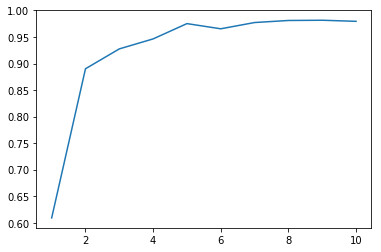

In [11]:
# Plot change in validation accuracy w.r.t number of epochs
n_epochs = np.arange(1, EPOCHS+1)
plt.plot(n_epochs, validation_accuracy)


In [12]:
with tf.Session() as sess:
    saver.restore(sess, './convNet')
    print('Model restored!')
    print()
    
    test_accuracy = evaluate(X_test, y_test)
    print('Accuracy on test set: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./convNet
Model restored!

Accuracy on test set: 0.9644497229009041


---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [13]:
import os

def load_additional_images(folder):
    images = []
    csv_file = pd.read_csv(os.path.join(folder, 'labels.csv'))
    file_names = csv_file.Image.as_matrix()
    labels = list(csv_file.Label.as_matrix())
    image_labels = []
    
    for filename in os.listdir(folder):
        if filename != 'labels.csv':
            img = cv2.imread(os.path.join(folder, filename))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            if img is not None:
                img = cv2.resize(img, (image_shape[0], image_shape[1]))
                images.append(img)
                
            index = np.where(file_names==filename)[0][0]
            image_labels.append(labels[index])
    return np.array(images), np.array(image_labels)

Loaded 5 Additional Images!


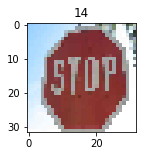

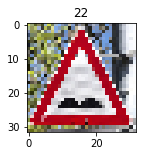

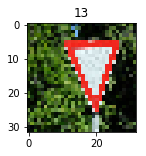

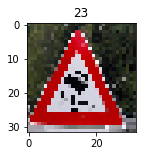

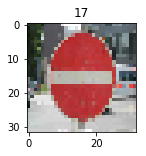

In [14]:
additional_images_folder = 'Additional Images'

add_imgs, labels = load_additional_images(additional_images_folder)
n_add_imgs = len(add_imgs)
print('Loaded {} Additional Images!'.format(n_add_imgs))

for image in range (len(add_imgs)):
    plt.figure(figsize=(2,2))
    plt.title(labels[image])
    plt.imshow(add_imgs[image])
    
additional_images = rgb_2_gray(add_imgs)
additional_images = normalize_gray(additional_images)

### Predict the Sign Type for Each Image

In [15]:
def prediction(image, label):
    image = np.expand_dims(image, 0)
    sess = tf.get_default_session()
    sm, accuracy = sess.run([softmax, accuracy_operation], feed_dict={x: image, y: [label], keep_prob: 1.0})
    return sm, accuracy

def get_top_k_softmax(softmax, k):
    sess = tf.get_default_session()
    top_k = sess.run(tf.nn.top_k(tf.constant(softmax), k=k))
    return top_k

INFO:tensorflow:Restoring parameters from ./convNet
Model restored!
Actual label: 14, Top 5 predicted labels: [14  2  8  5  1]
Actual label: 22, Top 5 predicted labels: [22 20 18 26 25]
Actual label: 13, Top 5 predicted labels: [13  2  5  1 38]
Actual label: 23, Top 5 predicted labels: [23 30 20 11 29]
Actual label: 17, Top 5 predicted labels: [17 33 14  9  8]


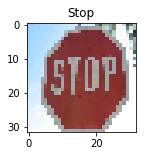

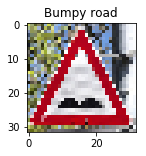

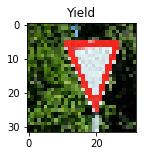

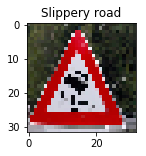

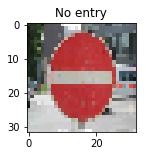

In [16]:
k = 5
total_accuracy = 0

with tf.Session() as sess:
    saver.restore(sess, './convNet')
    print('Model restored!')

    for i in range(n_add_imgs):
        sm, accuracy = prediction(additional_images[i], labels[i])
        total_accuracy += accuracy
        if accuracy == 1:
            plt.figure(figsize=(2,2))
            plt.title(label_names[labels[i]])
            plt.imshow(add_imgs[i])

        print('Actual label: {}, Top {} predicted labels: {}'.format(labels[i], k, get_top_k_softmax(sm, k)[1][0]))

### Analyze Performance

In [17]:
print('Total additional images used: {}'.format(n_add_imgs))
print('No. of correct predictions: {}, No. of incorrect predictions: {}'.format(int(total_accuracy), int(total_accuracy-n_add_imgs)))
print('Overall accuracy: {}%'.format(total_accuracy*100/n_add_imgs))

Total additional images used: 5
No. of correct predictions: 5, No. of incorrect predictions: 0
Overall accuracy: 100.0%


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [18]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")